# K-Nearest Neighbors: Predicting Player Market Values

## What is K-Nearest Neighbors?
K-Nearest Neighbors (KNN) is a versatile machine learning algorithm that can be used for both classification and regression tasks. For regression, it works by:
1. Finding the K nearest neighbors to a given data point
2. Taking the average of their target values as the prediction
3. Making predictions without explicitly learning any parameters

## Our Task
We'll use KNN regression to predict player market values based on their attributes. This approach should handle the different behaviors for high and low valued players which linear and neural network tried to generalize, potentially leading to better predictions for players with similar characteristics.

## Implementation

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import heapq

def distance(p, q):
    return np.linalg.norm(p - q)
	
def k_nearest_neighbors(point, training_features, training_labels, k):
	# Max-heap to store the k closest neighbors
	heap = []

	i = 0
	for p, label in zip(training_features, training_labels):
		# print(p)
		d = distance(point, p)
		# Use -d to simulate a max-heap (since heapq is min-heap by default)
		if len(heap) < k:
			heapq.heappush(heap, (-d, i, label, 1))
		else:
			heapq.heappush(heap, (-d, i, label, 1))
			heapq.heappop(heap)
		i+=1
	# Convert back to (point, label, distance) format
	return [(p, label, -neg_d) for (neg_d, i, label, p) in heap]



def KNN_Predict(point,
				training_features,
				training_labels,
				k,
				regression = False):
	neighbors = k_nearest_neighbors(point,
								   training_features,
								   training_labels,
								   k)
	
	if regression == False:
		labels = [x[1] for x in neighbors]
		return max(labels, key = labels.count)
	
	else:
		return sum(x[1] for x in neighbors)/k

## Understanding Our Dataset
Let's examine the key attributes we'll use to predict player market values:
- Overall Rating (primary indicator of player quality)
- Age (younger players often have higher market value potential)
- League Level (indicates competition quality)
- Contract Valid Until (remaining contract duration affects value)

KNN might be particularly effective here because players with similar attributes often have similar market values. For example, young players with high ratings in top leagues tend to command premium prices.

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

players_df = pd.read_csv("../data/players_data.csv")

# Select features for prediction
features = ["overall", "age", "league_level", "club_contract_valid_until_year"]
# Remove rows with NaN or null values
filtered_df = players_df.dropna(subset=features + ['value_eur'])
X = filtered_df[features].values
y = filtered_df['value_eur'].values

# Scale features and target because distances are sensitive to scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.4, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (10950, 4)
Test set shape: (7300, 4)


/var/folders/pz/s1ggtx853xx_qxny9g89ffgm0000gn/T/ipykernel_84032/1580559873.py:4: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  players_df = pd.read_csv("../data/players_data.csv")


## Predictions
Get the predictions based on 5 nearest neighbours.

This is slow ~2 minutes. Understandably so since we have to go over all training data. 

In [68]:
# Make predictions
k = 5  # number of neighbors to consider
y_pred = np.array([KNN_Predict(x, X_train, y_train, k, regression=True) for x in X_test])



## Model Evaluation
Let's evaluate our KNN model's performance by comparing predicted vs actual market values.

This is much better. We are able to predict with some good accuracy, estimates of market values.

We see an almost 90% reduction in MSE

Mean Squared Error: 0.0982


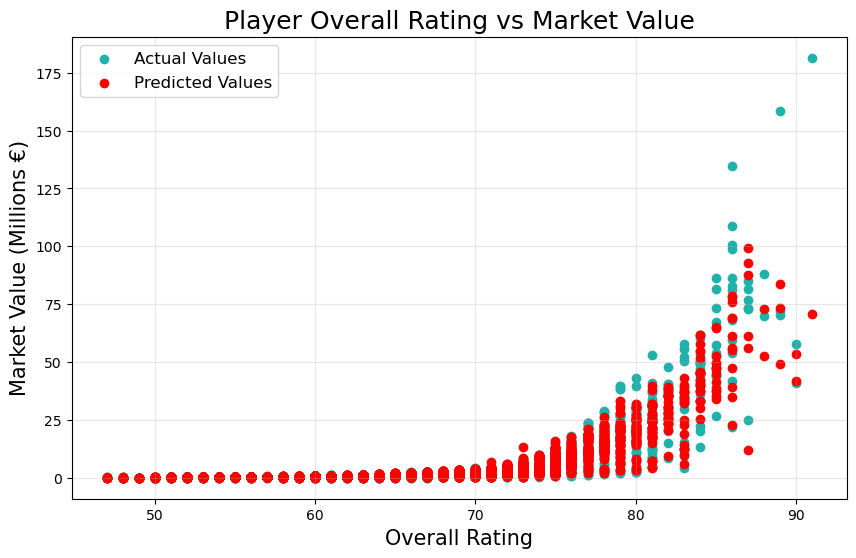

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))

# Get original scale values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
X_test_original = scaler_X.inverse_transform(X_test)
overall_ratings = X_test_original[:, 0]  # overall rating is first feature

# Convert market values to millions for better visualization
y_test_millions = y_test_original / 1_000_000

# Create scatter plot of actual values
plt.scatter(overall_ratings, y_test_millions, color='lightseagreen', label='Actual Values')

y_pred_millions = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel() / 1_000_000
plt.scatter(overall_ratings, y_pred_millions, color='red', label='Predicted Values')

plt.xlabel('Overall Rating', fontsize=15)
plt.ylabel('Market Value (Millions €)', fontsize=15)
plt.title('Player Overall Rating vs Market Value', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [73]:
from sklearn.metrics import mean_squared_error

# Compute MSE
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.0982
